In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys

sys.path.append('..')

from benchmark.himmelblau import Himmelblau
from benchmark.holder import Holder
from benchmark.rosenbrock import Rosenbrock
from benchmark.michalewicz import Michalewicz
from benchmark.sphere import Sphere
from benchmark.levy import Levy

from optims.N_CMA_ES import CMA_ES
from optims.WOA import WOA

from optims.SBS import SBS

In [2]:
def create_bounds(min, max, dim):
    bounds = [(min, max) for _ in range(dim)]
    return np.array(bounds)

In [3]:
fs = {
  "Himmelblau": [Himmelblau(), create_bounds(-4, 4, 2)],
  "Levy": [Levy(), create_bounds(-10, 10, 2)],
}

In [3]:
evals = np.linspace(100, 1_000_000, 10, dtype=int)

cma_results = {}
woa_results = {}
sbs_results = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]

  cma_results_tmp = []
  woa_results_tmp = []
  sbs_results_tmp = []
  for num_evals in evals:
    m_0 = np.random.uniform(bounds[:, 0], bounds[:, 1])
    cma = CMA_ES(bounds, m_0, max_evals=num_evals)
    opt = cma.optimize(h)[0][1]
    cma_results_tmp.append(np.abs(opt - h.min))

    woa = WOA(bounds, n_gen=30, n_sol=num_evals // 30)
    opt = woa.optimize(h)[0][1]
    woa_results_tmp.append(np.abs(opt - h.min))

    svgd_iter = 300
    n_particles = max(num_evals // (300 * 3), 1)

    sbs = SBS(
      bounds,
      n_particles=n_particles,
      k_iter=[10_000],
      svgd_iter=svgd_iter,
      sigma=1 / n_particles**2,
      lr=0.2
    )
    opt = sbs.optimize(h)[0][1]
    sbs_results_tmp.append(np.abs(opt - h.min))
  cma_results[f_name] = cma_results_tmp
  woa_results[f_name] = woa_results_tmp
  sbs_results[f_name] = sbs_results_tmp


  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
for f_name in fs.keys():
  plt.plot(evals, cma_results[f_name], label=f"CMA-ES")
  plt.plot(evals, woa_results[f_name], label=f"WOA")
  plt.plot(evals, sbs_results[f_name], label=f"SBS")
  plt.yscale("log")
  plt.xlabel("Number of evaluations")
  plt.ylabel("log distance to minimum")
  plt.legend()
  plt.title(f"Convergence of optimization algorithms on {f_name}")
  plt.savefig(f"fig/perf/perf_vs_evals_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [5]:
ns_particles = np.linspace(10, 2000, 10, dtype=int)

sbs_results_particles = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]
  sbs_results_particles_tmp = []

  for n_particles in ns_particles:
    sbs = SBS(
      bounds,
      n_particles=n_particles,
      k_iter=[10_000],
      svgd_iter=300,
      sigma=1 / n_particles**2,
      lr=0.2
    )
    opt = sbs.optimize(h)[0][1]
    sbs_results_particles_tmp.append(np.abs(opt - h.min))
  sbs_results_particles[f_name] = sbs_results_particles_tmp

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
for f_name in fs.keys():
  plt.plot(ns_particles, sbs_results_particles[f_name])
  plt.xlabel("Number of particles")
  plt.ylabel("log distance to minimum")
  plt.yscale("log")
  plt.title(f"Perf vs. Particles on {f_name}")
  plt.savefig(f"fig/perf/perf_vs_particles_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [4]:
ks = np.linspace(1, 10_000, 20, dtype=int)

sbs_results_k = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]
  sbs_results_k_tmp = []

  for k in ks:
    sbs = SBS(
      bounds,
      n_particles=300,
      k_iter=[k],
      svgd_iter=300,
      sigma=1 / 300**2,
      lr=0.2
    )
    opt = sbs.optimize(h)[0][1]
    sbs_results_k_tmp.append(np.abs(opt - h.min))
  sbs_results_k[f_name] = sbs_results_k_tmp

  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
for f_name in fs.keys():
  plt.plot(ks, sbs_results_k[f_name])
  plt.xlabel("$\kappa$")
  plt.ylabel("log distance to minimum")
  plt.yscale("log")
  plt.title(f"Perf vs. $\kappa$ on {f_name}")
  plt.savefig(f"fig/perf/perf_vs_k_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

<Figure size 640x480 with 0 Axes>

In [61]:
sigmas = np.linspace(1e-5, 1e-1, 20)

sbs_results_s = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]
  sbs_results_s_tmp = []

  for sigma in sigmas:
    sbs = SBS(
      bounds,
      n_particles=50,
      k_iter=[10000],
      svgd_iter=300,
      sigma=sigma,
      lr=0.2
    )
    opt = sbs.optimize(h)[0][1]
    sbs_results_s_tmp.append(np.abs(opt - h.min))
  sbs_results_s[f_name] = sbs_results_s_tmp

  0%|          | 0/1 [00:00<?, ?it/s]

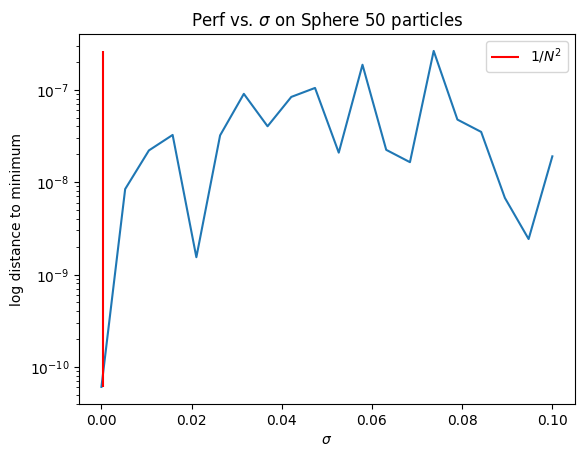

<Figure size 640x480 with 0 Axes>

In [62]:
for f_name in fs.keys():
  plt.plot(sigmas, sbs_results_s[f_name])
  plt.vlines(1 / 50**2, min(sbs_results_s[f_name]), max(sbs_results_s[f_name]), color="red", label="$1 / N^2$")
  plt.xlabel("$\sigma$")
  plt.ylabel("log distance to minimum")
  plt.yscale("log")
  plt.title(f"Perf vs. $\sigma$ on {f_name} 50 particles")
  plt.legend()
  plt.show()
  #plt.savefig(f"fig/perf/perf_vs_k_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()

In [69]:
sigmas = np.linspace(1e-5, 1e-1, 20)

sbs_results_s = {}

for f_name in tqdm(fs.keys()):
  h = fs[f_name][0]
  bounds = fs[f_name][1]
  sbs_results_s_tmp = []

  for sigma in sigmas:
    sbs = SBS(
      bounds,
      n_particles=300,
      k_iter=[10000],
      svgd_iter=300,
      sigma=sigma,
      lr=0.2
    )
    opt = sbs.optimize(h)[0][1]
    sbs_results_s_tmp.append(np.abs(opt - h.min))
  sbs_results_s[f_name] = sbs_results_s_tmp

  0%|          | 0/1 [00:00<?, ?it/s]

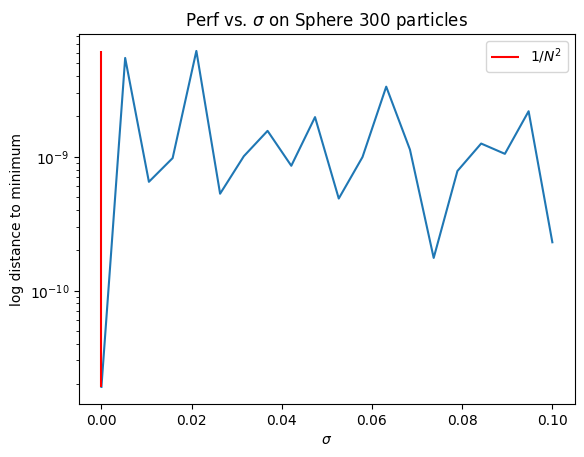

<Figure size 640x480 with 0 Axes>

In [72]:
for f_name in fs.keys():
  plt.plot(sigmas, sbs_results_s[f_name])
  plt.vlines(1 / 300**2, min(sbs_results_s[f_name]), max(sbs_results_s[f_name]), color="red", label="$1 / N^2$")
  plt.xlabel("$\sigma$")
  plt.ylabel("log distance to minimum")
  plt.yscale("log")
  plt.title(f"Perf vs. $\sigma$ on {f_name} 300 particles")
  plt.legend()
  plt.show()
  #plt.savefig(f"fig/perf/perf_vs_k_{f_name}.png", bbox_inches="tight", dpi=300)
  plt.clf()